# Partie 1 : Analyse descriptive et exploratoire des données

In [86]:
# 1. Import des bibliothèques
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [87]:
# Configurations pour les graphiques
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

# 2. Chargement du fichier JSONL
file_path = "../data/prompts_completions.jsonl"

data = []
with open(file_path, 'r', encoding='utf-8') as f:
    for line in f:
        item = json.loads(line)
        data.append(item)

df = pd.DataFrame(data)

# 3. Aperçu des données
df.head()

,prompt,completion
0,Je veux faire une demande de : inscription à l...,Description : Ce service permet d’obtenir le d...
1,Je veux faire une demande de : permis de const...,Description : Il vise à fournir un justificati...
2,Je veux faire une demande de : régularisation ...,Description : Ce service est indispensable pou...
3,Je veux faire une demande de : duplicata de ca...,Description : Il vise à fournir un justificati...
4,Je veux faire une demande de : duplicata de ca...,Description : Il vise à fournir un justificati...


In [88]:
# Vue d'ensemble du dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   prompt      1000 non-null   object
 1   completion  1000 non-null   object
dtypes: object(2)
memory usage: 15.8+ KB


In [89]:
# Nombre d'exemples
print(f"Nombre total d'exemples : {len(df)}")
# Valeurs manquantes
print("Valeurs manquantes :")
print(df.isnull().sum())

# Doublons
print(f"Doublons : {df.duplicated().sum()}")

Nombre total d'exemples : 1000
Valeurs manquantes :
prompt        0
completion    0
dtype: int64
Doublons : 167


In [90]:
# Ajout des longueurs
df['prompt_len'] = df['prompt'].apply(lambda x: len(x.split()))
df['completion_len'] = df['completion'].apply(lambda x: len(x.split()))

# Statistiques descriptives
df[['prompt_len', 'completion_len']].describe()

,prompt_len,completion_len
count,1000.000000,1000.000000
mean,10.729000,48.427000
std,1.010237,1.896383
min,9.000000,44.000000
25%,10.000000,47.000000
50%,11.000000,48.000000
75%,11.000000,49.000000
max,13.000000,56.000000


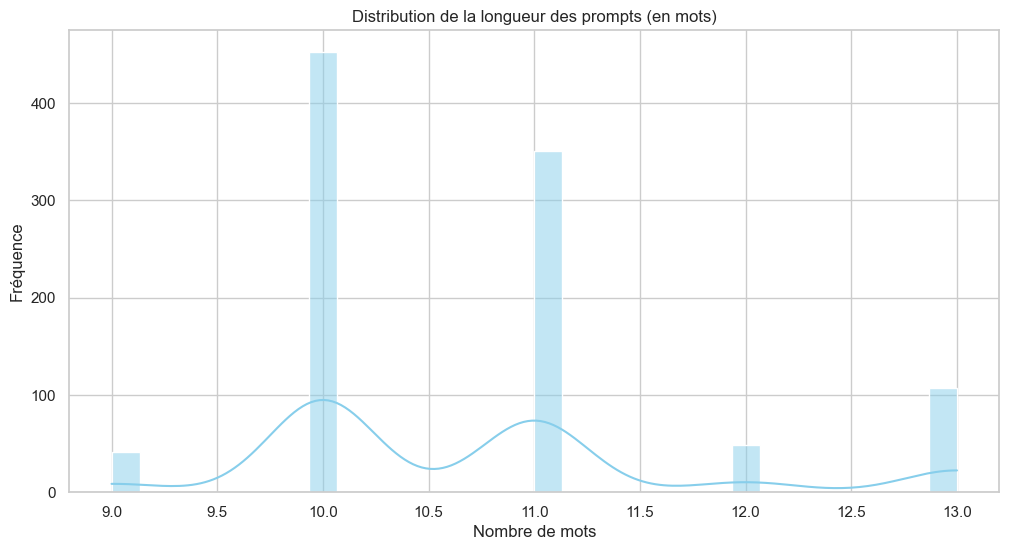

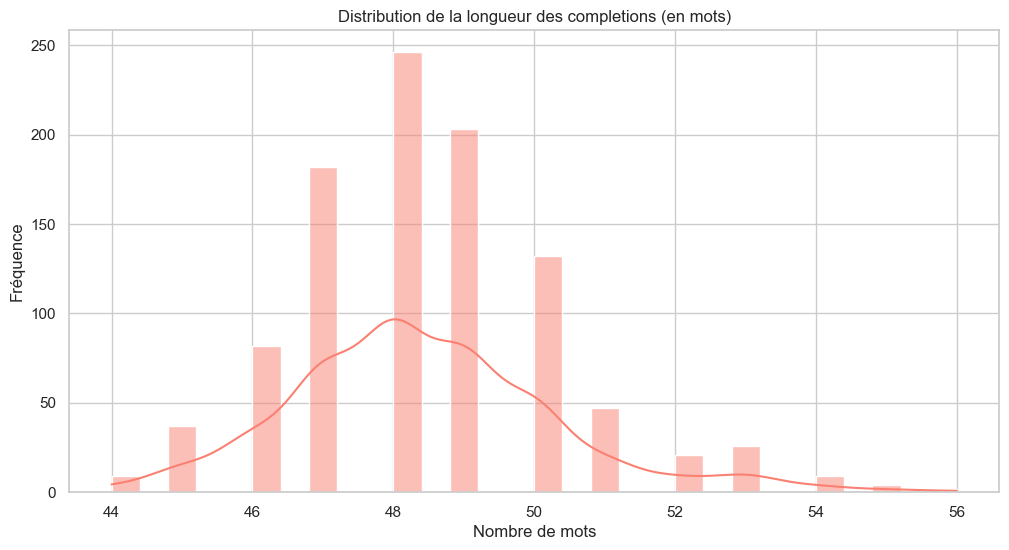

In [91]:
# Longueur des prompts
sns.histplot(df['prompt_len'], bins=30, kde=True, color='skyblue')
plt.title("Distribution de la longueur des prompts (en mots)")
plt.xlabel("Nombre de mots")
plt.ylabel("Fréquence")
plt.show()

# Longueur des completions
sns.histplot(df['completion_len'], bins=30, kde=True, color='salmon')
plt.title("Distribution de la longueur des completions (en mots)")
plt.xlabel("Nombre de mots")
plt.ylabel("Fréquence")
plt.show()


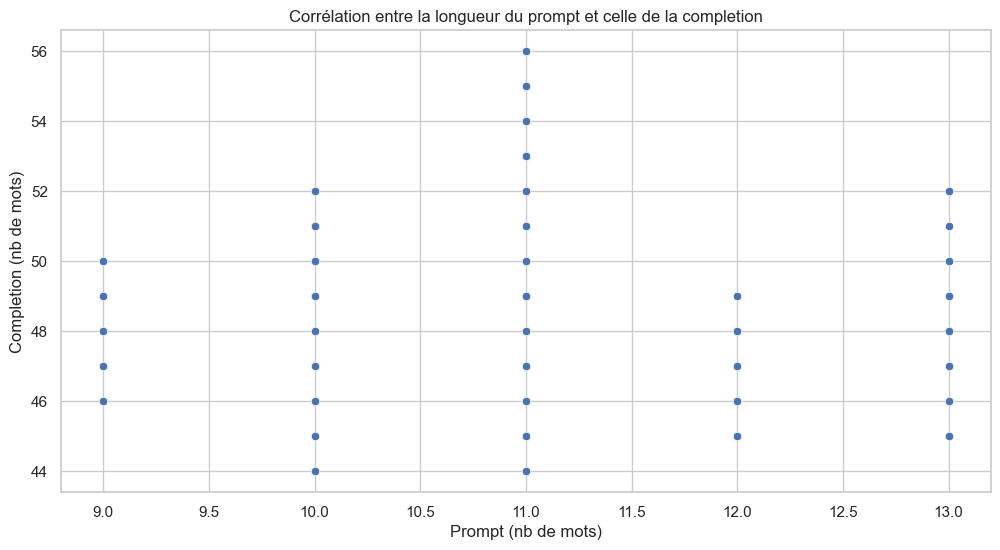

In [92]:
sns.scatterplot(data=df, x='prompt_len', y='completion_len')
plt.title("Corrélation entre la longueur du prompt et celle de la completion")
plt.xlabel("Prompt (nb de mots)")
plt.ylabel("Completion (nb de mots)")
plt.show()

In [93]:
# Suppression des valeurs manquantes ou vides
df_cleaned = df.dropna()
df_cleaned = df_cleaned[(df_cleaned['prompt'].str.strip() != "") & (df_cleaned['completion'].str.strip() != "")]

# Suppression des doublons
df_cleaned = df_cleaned.drop_duplicates()

print(f"Nombre d'exemples après nettoyage : {len(df_cleaned)}")

Nombre d'exemples après nettoyage : 833


In [94]:
print(df_cleaned.head())

                                              prompt  \
0  Je veux faire une demande de : inscription à l...   
1  Je veux faire une demande de : permis de const...   
2  Je veux faire une demande de : régularisation ...   
3  Je veux faire une demande de : duplicata de ca...   
4  Je veux faire une demande de : duplicata de ca...   

                                          completion  prompt_len  \
0  Description : Ce service permet d’obtenir le d...          11   
1  Description : Il vise à fournir un justificati...          10   
2  Description : Ce service est indispensable pou...          11   
3  Description : Il vise à fournir un justificati...          11   
4  Description : Il vise à fournir un justificati...          11   

   completion_len  
0              48  
1              48  
2              56  
3              48  
4              47  


# Partie 2 : Préparation des données pour le modèle

In [95]:
import json
import pandas as pd
from collections import defaultdict
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [96]:
# Lecture du fichier JSONL
data = []
with open("../data/prompts_completions.jsonl", "r", encoding="utf-8") as f:
    for line in f:
        data.append(json.loads(line.strip()))

df = pd.DataFrame(data)
df.head()

,prompt,completion
0,Je veux faire une demande de : inscription à l...,Description : Ce service permet d’obtenir le d...
1,Je veux faire une demande de : permis de const...,Description : Il vise à fournir un justificati...
2,Je veux faire une demande de : régularisation ...,Description : Ce service est indispensable pou...
3,Je veux faire une demande de : duplicata de ca...,Description : Il vise à fournir un justificati...
4,Je veux faire une demande de : duplicata de ca...,Description : Il vise à fournir un justificati...


In [97]:
df = df_cleaned

In [98]:
def clean_text(text):
    text = text.lower().strip()
    return text.replace(":", " :").replace("\n", " ")  # séparateur logique pour les tokens

df['prompt_clean'] = df['prompt'].apply(clean_text)
df['completion_clean'] = df['completion'].apply(lambda x: "<sos> " + clean_text(x) + " <eos>")

In [99]:
# Tokenisation (split sur les espaces)

df['prompt_tokens'] = df['prompt_clean'].apply(lambda x: x.split())
df['completion_tokens'] = df['completion_clean'].apply(lambda x: x.split())

In [100]:
# Création du vocabulaire

word2idx = {"<pad>": 0, "<unk>": 1, "<sos>": 2, "<eos>": 3}
idx = 4

for tokens in df['prompt_tokens'].tolist() + df['completion_tokens'].tolist():
    for token in tokens:
        if token not in word2idx:
            word2idx[token] = idx
            idx += 1

idx2word = {i: w for w, i in word2idx.items()}
vocab_size = len(word2idx)
print(f"Vocab size: {vocab_size}")

Vocab size: 173


In [101]:
#  Encodage des tokens

def encode(tokens, word2idx):
    return [word2idx.get(token, word2idx["<unk>"]) for token in tokens]

df['prompt_ids'] = df['prompt_tokens'].apply(lambda x: encode(x, word2idx))
df['completion_ids'] = df['completion_tokens'].apply(lambda x: encode(x, word2idx))

In [102]:
# Padding des séquences

def pad_sequence(seq, max_len):
    return seq + [0] * (max_len - len(seq)) if len(seq) < max_len else seq[:max_len]

max_prompt_len = max(df['prompt_ids'].apply(len))
max_completion_len = max(df['completion_ids'].apply(len))

df['prompt_padded'] = df['prompt_ids'].apply(lambda x: pad_sequence(x, max_prompt_len))
df['completion_padded'] = df['completion_ids'].apply(lambda x: pad_sequence(x, max_completion_len))

In [103]:
# Création du Dataset PyTorch

class DémarcheDataset(Dataset):
    def __init__(self, df):
        self.inputs = torch.tensor(df['prompt_padded'].tolist(), dtype=torch.long)
        self.targets = torch.tensor(df['completion_padded'].tolist(), dtype=torch.long)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx]

dataset = DémarcheDataset(df)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

In [104]:
# Split train / validation

from torch.utils.data import DataLoader, random_split

import scipy
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

# Partie 3 : Construction du modèle Seq2Seq avec PyTorch

In [105]:
# Classe du modèle 'Seq2SeqModel'

import torch
import torch.nn as nn

class Seq2SeqModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, pad_idx, sos_idx, eos_idx):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)
        self.encoder = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.decoder = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.fc_out = nn.Linear(hidden_dim, vocab_size)
        self.sos_idx = sos_idx
        self.eos_idx = eos_idx

    def forward(self, src, tgt):
        # Teacher forcing
        embedded_src = self.embedding(src)
        embedded_tgt = self.embedding(tgt)
        _, (hidden, cell) = self.encoder(embedded_src)
        outputs, _ = self.decoder(embedded_tgt, (hidden, cell))
        logits = self.fc_out(outputs)
        return logits

    def generate(self, src, max_len=50, device=None):
        device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.eval()
        src = src.to(device)
        embedded_src = self.embedding(src)
        _, (hidden, cell) = self.encoder(embedded_src)

        input_token = torch.tensor([[self.sos_idx]], device=device)
        generated_indices = []

        for _ in range(max_len):
            embedded = self.embedding(input_token)
            output, (hidden, cell) = self.decoder(embedded, (hidden, cell))
            logits = self.fc_out(output.squeeze(1))
            next_token = torch.argmax(logits, dim=1)

            if next_token.item() == self.eos_idx:
                break

            generated_indices.append(next_token.item())
            input_token = next_token.unsqueeze(0)  # batch size = 1

        return generated_indices

In [106]:
# Définition des hyperparamètres et initialisation

# Initialisation
model = Seq2SeqModel(
    vocab_size=len(word2idx),
    embed_dim=128,
    hidden_dim=256,
    pad_idx=word2idx["<pad>"],
    sos_idx=word2idx["<sos>"],
    eos_idx=word2idx["<eos>"]
)

In [107]:
vocab = word2idx

In [108]:
#  Définition de la fonction de perte et de l’optimiseur

criterion = nn.CrossEntropyLoss(ignore_index=word2idx["<pad>"])
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [109]:
# Vérification rapide : test avec un batch dummy :

# Dummy input (batch_size=2, seq_len=10)
src = torch.randint(0, len(vocab), (2, 10))  # prompt encodé
tgt = torch.randint(0, len(vocab), (2, 10))  # completion encodée

out = model(src, tgt)
print("Logits shape :", out.shape)  # Should be [2, 10, vocab_size]

Logits shape : torch.Size([2, 10, 173])


In [110]:
# Chemin de sauvegarde
vocab_path = "../models/vocab.json"

# Sauvegarde du vocabulaire
with open(vocab_path, "w", encoding="utf-8") as f:
    json.dump(vocab, f, ensure_ascii=False, indent=4)

print(f"Vocabulaire sauvegardé dans : {vocab_path}")

Vocabulaire sauvegardé dans : ../models/vocab.json


# Partie 4 : Entraînement du modèle

In [111]:
# Préparation des dataloader

from torch.utils.data import DataLoader

batch_size = 32

train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


In [112]:
# Boucle d'entrainement 

import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for batch in train_loader:
        src, tgt = batch
        src, tgt = src.to(device), tgt.to(device)

        optimizer.zero_grad()

        output = model(src, tgt[:, :-1])  # input without the last token
        loss = criterion(output.reshape(-1, output.shape[-1]), tgt[:, 1:].reshape(-1))  # target without the first token

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Époque {epoch + 1}/{num_epochs}, Loss : {avg_loss:.4f}")


Époque 1/10, Loss : 3.6821
Époque 2/10, Loss : 1.0416
Époque 3/10, Loss : 0.3232
Époque 4/10, Loss : 0.2113
Époque 5/10, Loss : 0.1842
Époque 6/10, Loss : 0.1721
Époque 7/10, Loss : 0.1672
Époque 8/10, Loss : 0.1639
Époque 9/10, Loss : 0.1622
Époque 10/10, Loss : 0.1612


In [113]:
# Entrainement du modèle

import matplotlib.pyplot as plt

# Initialisation
train_losses = []
val_losses = []
best_val_loss = float('inf')

for epoch in range(num_epochs):
    model.train()
    train_loss = 0

    for src, tgt in train_loader:
        src, tgt = src.to(device), tgt.to(device)
        optimizer.zero_grad()
        output = model(src, tgt[:, :-1])
        loss = criterion(output.reshape(-1, output.shape[-1]), tgt[:, 1:].reshape(-1))
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for src, tgt in val_loader:
            src, tgt = src.to(device), tgt.to(device)
            output = model(src, tgt[:, :-1])
            loss = criterion(output.reshape(-1, output.shape[-1]), tgt[:, 1:].reshape(-1))
            val_loss += loss.item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    print(f"Époque {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    # Sauvegarde du meilleur modèle
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save({
            "model_state_dict": model.state_dict(),
            "vocab": word2idx,
        }, "../models/best_seq2seq_model.pth")
        print("🔁 Nouveau meilleur modèle sauvegardé")

Époque 1/10 | Train Loss: 0.1572 | Val Loss: 0.1572
🔁 Nouveau meilleur modèle sauvegardé
Époque 2/10 | Train Loss: 0.1570 | Val Loss: 0.1550
🔁 Nouveau meilleur modèle sauvegardé
Époque 3/10 | Train Loss: 0.1570 | Val Loss: 0.1559
Époque 4/10 | Train Loss: 0.1549 | Val Loss: 0.1565
Époque 5/10 | Train Loss: 0.1560 | Val Loss: 0.1561
Époque 6/10 | Train Loss: 0.1557 | Val Loss: 0.1553
Époque 7/10 | Train Loss: 0.1541 | Val Loss: 0.1537
🔁 Nouveau meilleur modèle sauvegardé
Époque 8/10 | Train Loss: 0.1539 | Val Loss: 0.1531
🔁 Nouveau meilleur modèle sauvegardé
Époque 9/10 | Train Loss: 0.1535 | Val Loss: 0.1542
Époque 10/10 | Train Loss: 0.1534 | Val Loss: 0.1522
🔁 Nouveau meilleur modèle sauvegardé


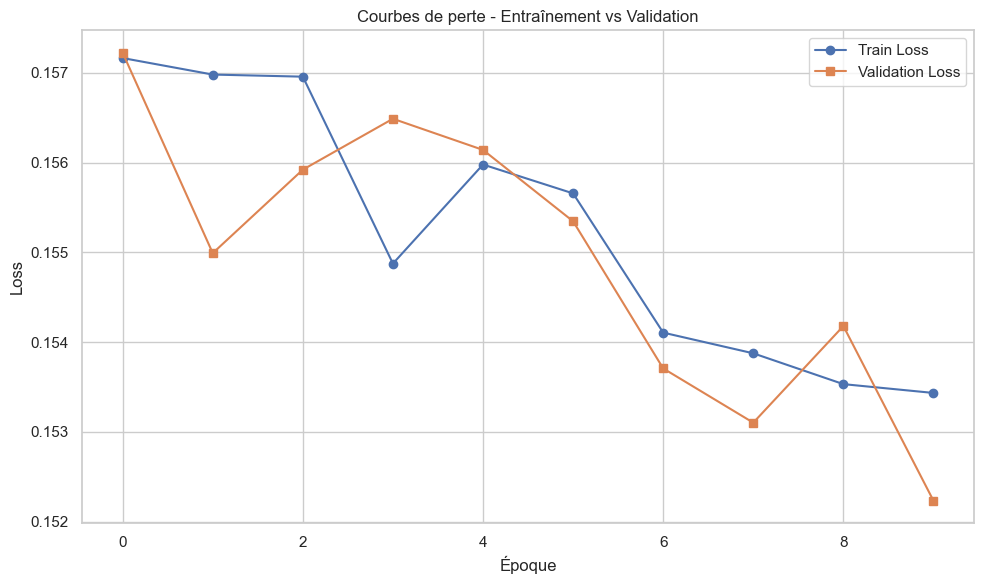

In [114]:
# Affichage des courbes de perte
plt.figure(figsize=(10,6))
plt.plot(train_losses, label="Train Loss", marker="o")
plt.plot(val_losses, label="Validation Loss", marker="s")
plt.xlabel("Époque")
plt.ylabel("Loss")
plt.title("Courbes de perte - Entraînement vs Validation")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [115]:
#  Sauvegarde du modèle

torch.save(model.state_dict(), "../models/seq2seq_model.pth")

In [116]:
# Recharger le modèle pour prédire

model.load_state_dict(torch.load("../models/seq2seq_model.pth"))
model.eval()

Seq2SeqModel(
  (embedding): Embedding(173, 128, padding_idx=0)
  (encoder): LSTM(128, 256, batch_first=True)
  (decoder): LSTM(128, 256, batch_first=True)
  (fc_out): Linear(in_features=256, out_features=173, bias=True)
)

In [117]:
def prepare_input(text, vocab, device):
    tokens = text.strip().split()
    tokens = ["<sos>"] + tokens + ["<eos>"]
    indices = [vocab.get(token, vocab["<unk>"]) for token in tokens]
    tensor = torch.tensor(indices, dtype=torch.long).unsqueeze(0).to(device)  # Shape: (1, seq_len)
    return tensor

def decode(indices, idx2word):
    words = [idx2word[idx] for idx in indices if idx2word[idx] not in ("<pad>", "<sos>", "<eos>")]
    return " ".join(words)


def generate_response(prompt, model, vocab, idx2word, max_len=50, device=None):
    device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    model.to(device)

    src_tensor = prepare_input(prompt, vocab, device)

    with torch.no_grad():
        embedded_src = model.embedding(src_tensor)
        _, (hidden, cell) = model.encoder(embedded_src)

    generated_indices = [vocab["<sos>"]]

    for _ in range(max_len):
        current_input = torch.tensor([[generated_indices[-1]]], dtype=torch.long).to(device)
        with torch.no_grad():
            embedded = model.embedding(current_input)
            output, (hidden, cell) = model.decoder(embedded, (hidden, cell))
            logits = model.fc_out(output.squeeze(1))
            predicted_idx = torch.argmax(logits, dim=1).item()

        if predicted_idx == vocab["<eos>"]:
            break

        generated_indices.append(predicted_idx)

    return decode(generated_indices[1:], idx2word)


In [118]:
prompt = "Je veux faire une demande de : immatriculation d'un véhicule"
response = generate_response(prompt, model, word2idx, idx2word)
print("🔹 Prompt :", prompt)
print("🔸 Réponse générée :", response)

🔹 Prompt : Je veux faire une demande de : immatriculation d'un véhicule
🔸 Réponse générée : description : ce service permet d’obtenir le document requis en toute légalité. durée estimée : 48h qui peut faire la demande ? tout citoyen béninois disposant des pièces requises. institution en charge : ministère de la justice démarches : faire une préinscription en ligne puis finaliser en agence.


In [119]:
import torch.nn.functional as F
import random

def sample_response(prompt, model, vocab, idx2word, max_len=50, temperature=1.0, device=None):
    device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    model.to(device)

    src_tensor = prepare_input(prompt, vocab, device)
    with torch.no_grad():
        embedded_src = model.embedding(src_tensor)
        _, (hidden, cell) = model.encoder(embedded_src)

    generated_indices = [vocab["<sos>"]]

    for _ in range(max_len):
        current_input = torch.tensor([[generated_indices[-1]]], dtype=torch.long).to(device)
        with torch.no_grad():
            embedded = model.embedding(current_input)
            output, (hidden, cell) = model.decoder(embedded, (hidden, cell))
            logits = model.fc_out(output.squeeze(1)) / temperature
            probs = F.softmax(logits, dim=1)
            predicted_idx = torch.multinomial(probs, num_samples=1).item()

        if predicted_idx == vocab["<eos>"]:
            break

        generated_indices.append(predicted_idx)

    return decode(generated_indices[1:], idx2word)

In [120]:
prompt = "Je veux faire une demande de : inscription à l'état civil"
print(sample_response(prompt, model, word2idx, idx2word))

description : ce processus facilite l'obtention du document par les voies réglementaires. durée estimée : 48h qui peut faire la demande ? tout citoyen béninois disposant des pièces requises. institution en charge : mairie de cotonou démarches : faire une préinscription en ligne puis finaliser en agence.


In [121]:
import torch

def generate_completion(prompt_text, model, word2idx, idx2word, max_len=80, temperature=1.0, device=None):
    """
    Génère une complétion à partir d'un prompt donné, avec sampling.

    Args:
        prompt_text (str): Texte d'entrée (prompt).
        model (nn.Module): Modèle seq2seq entraîné.
        word2idx (dict): Vocabulaire mot -> index.
        idx2word (dict): Index -> mot.
        max_len (int): Longueur max de la complétion.
        temperature (float): Température pour la distribution de probas.
        device (torch.device): Appareil (CPU/GPU).

    Returns:
        str: Texte généré.
    """
    device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    model.to(device)

    # Prépare la séquence d'entrée encodée (tensor 1D)
    src_tensor = prepare_input(prompt_text, word2idx, device)  # -> (1, src_len)
    
    # Encode l'entrée
    with torch.no_grad():
        embedded_src = model.embedding(src_tensor)
        _, (hidden, cell) = model.encoder(embedded_src)

    # Démarre la génération avec <sos>
    input_token = torch.tensor([[word2idx["<sos>"]]], dtype=torch.long).to(device)  # (1,1)
    generated_tokens = []

    for _ in range(max_len):
        embedded_input = model.embedding(input_token)  # (1,1,embed_dim)
        output, (hidden, cell) = model.decoder(embedded_input, (hidden, cell))  # output: (1,1,hidden_dim)
        logits = model.fc_out(output.squeeze(1)) / temperature  # (1, vocab_size)
        probs = torch.softmax(logits, dim=-1)

        # Sample un token selon la distribution
        next_token = torch.multinomial(probs, num_samples=1)  # (1,1)

        token_id = next_token.item()
        if token_id == word2idx["<eos>"]:
            break

        generated_tokens.append(token_id)
        input_token = next_token.view(1, 1)  # assure shape (1,1)

    # Convertir la liste d’indices en mots
    generated_words = [idx2word[idx] for idx in generated_tokens]

    return " ".join(generated_words)

In [125]:
prompt = "Je veux faire une demande de : régularisation de terrain domanial"
completion = generate_completion(prompt, model, word2idx, idx2word, max_len=50, temperature=0.8, device=device)
print("Prompt :", prompt)
print("Complétion :", completion)

Prompt : Je veux faire une demande de : régularisation de terrain domanial
Complétion : description : ce service est indispensable pour toute personne concernée par cette situation. durée estimée : 72h qui peut faire la demande ? tout citoyen béninois disposant des pièces requises. institution en charge : mairie de résidence démarches : faire une préinscription en ligne puis finaliser en agence.
